In [2]:
import sys
sys.path.insert(0, '/tf/utils/')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import performance

In [4]:
# 1. Abre os arquivos e os coloca em dataframes
file1 = '/tf/Etapa 2/resultados finais/kalman_2024-04-13_06-57-44.xlsx'
file2 = '/tf/Etapa 2/resultados finais/wiener_2024-04-12_21-23-26.xlsx'
file3 = '/tf/Etapa 3/UNet/metrics/resunet_2023-11-04_20-29-28.xlsx'
file4 = '/tf/Etapa 3/UNet/metrics/gan-pix2pix_2023-11-06_18-11-21.xlsx'
file5 = '/tf/Etapa 3/Artigos/Non Intrusive PESQNet/DNS-metrics_2023-11-12_06-25-17.xlsx'
file6 = '/tf/Etapa 3/UNet/metrics/ResUnetConvLSTM-metrics_2023-11-12_14-46-51.xlsx'

In [5]:
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)
df3 = pd.read_excel(file3)
df4 = pd.read_excel(file4)
df5 = pd.read_excel(file5)
df6 = pd.read_excel(file6)

In [6]:
# performance(df1, 'Kalman')

In [7]:
# performance(df2, 'Wiener')

In [8]:
def summarize_results(df1):

    # Defina os intervalos de SNR
    bins = [0, 5, 10, 15, 20]
    labels = ['0-5dB', '5-10dB', '10-15dB', '15-20dB']
    
    # Adicione uma nova coluna ao DataFrame original com os rótulos dos intervalos de SNR
    df1['SNR Interval'] = pd.cut(df1['SNR'], bins=bins, labels=labels)
    
    # Função para calcular a porcentagem de sinal melhorado
    def signal_improvement_count(group):
        return (group['PESQ'] < group['PESQ (Filtered)']).mean(), (group['STOI'] < group['STOI (Filtered)']).mean()
    
    # Agregação dos dados
    agg_func = {
        'PESQ': ['mean', 'std'],
        'STOI': ['mean', 'std'],
        'PESQ (Filtered)': ['mean', 'std'],
        'STOI (Filtered)': ['mean', 'std'],
        'SNR (Filtered)': ['mean', 'std'],
    }
    
    # Agrupe o DataFrame e aplique as funções de agregação
    result = df1.groupby('SNR Interval').agg(agg_func)
    
    # Calcule a porcentagem de sinal melhorado e adicione as colunas ao DataFrame resultante
    result['% Sinal Melhorado (PESQ)'], result['% Sinal Melhorado (STOI)'] = zip(*df1.groupby('SNR Interval').apply(signal_improvement_count))
    
    # Renomeie as colunas
    result.columns = [f'{col[0]} {col[1]}' for col in result.columns]
    
    # Resetar o índice
    result = result.reset_index()
    
    # Contagem de sons em cada intervalo de SNR
    sound_count = df1['SNR Interval'].value_counts().reset_index()
    sound_count.columns = ['SNR Interval', 'Número de Sons']
    
    # Mesclar a contagem no DataFrame resultante
    result = result.merge(sound_count, on='SNR Interval')

    # # Combine as colunas "mean" e "std"
    # for col_name in result.columns:
    #     if "mean" in col_name:
    #         std_col_name = col_name.replace("mean", "std")
    #         result[col_name] = result[col_name].round(2).astype(str) + " ± " + result[std_col_name].round(2).astype(str)


    return result

In [9]:
result_kalman = summarize_results(df1)
result_wiener = summarize_results(df2)
result_unet = summarize_results(df3)
result_gan = summarize_results(df4)
result_fcrn = summarize_results(df5)
result_unetconv = summarize_results(df6)

In [10]:
def plot_summarized_results(df1, name_df1, df2, name_df2):
    # Defina o deslocamento horizontal para os gráficos
    x = np.arange(len(df1['SNR Interval']))

    x_title = 'Faixa de SNR'

    # Defina a largura das barras
    bar_width = 0.3
    figsize = (12, 4)
    
    # Defina uma paleta de cores de tons de vermelho
    colors = ['darkred', 'firebrick', 'indianred']
    
    # Função para adicionar rótulos de dados centralizados
    def autolabel(bars, hval=2, f=2):
        for bar in bars:
            height = bar.get_height()
            if f == 1:
                plt.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height/hval), xytext=(0, 3), textcoords='offset points',
                             ha='center', va='bottom', fontweight='bold', color='white')
            else:
                plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height/hval), xytext=(0, 3), textcoords='offset points',
                         ha='center', va='bottom', fontweight='bold', color='white')
    
    # Gráfico 1: PESQ, PESQ (Filtered) - df1, PESQ (Filtered) - df2
    plt.figure(figsize=figsize)
    bars1 = plt.bar(x - bar_width, df1['PESQ mean'], width=bar_width, label='PESQ - Ruidoso', yerr=df1['PESQ std'], color=colors[0])
    bars2 = plt.bar(x, df1['PESQ (Filtered) mean'], width=bar_width, label=f'PESQ - {name_df1}', yerr=df1['PESQ (Filtered) std'], color=colors[1])
    bars3 = plt.bar(x + bar_width, df2['PESQ (Filtered) mean'], width=bar_width, label=f'PESQ - {name_df2}', yerr=df2['PESQ (Filtered) std'], color=colors[2])
    plt.xlabel(x_title)
    plt.ylabel('Média - PESQ')
    plt.title('Comparação - PESQ')
    plt.xticks(x, df1['SNR Interval'])

    plt.ylim(1.0, 3)
    
    # Adicione rótulos de dados às barras
    autolabel(bars1, hval=1.4)
    autolabel(bars2, hval=1.4)
    autolabel(bars3, hval=1.4)
    
    plt.legend(loc='upper left')
    
    # Gráfico 2: STOI, STOI (Filtered) - df1, STOI (Filtered) - df2
    plt.figure(figsize=figsize)
    bars1 = plt.bar(x - bar_width, df1['STOI mean'], width=bar_width, label='STOI Ruidoso', yerr=df1['STOI std'], color=colors[0])
    bars2 = plt.bar(x, df1['STOI (Filtered) mean'], width=bar_width, label=f'STOI - {name_df1}', yerr=df1['STOI (Filtered) std'], color=colors[1])
    bars3 = plt.bar(x + bar_width, df2['STOI (Filtered) mean'], width=bar_width, label=f'STOI - {name_df2}', yerr=df2['STOI (Filtered) std'], color=colors[2])
    plt.xlabel(x_title)
    plt.ylabel('Média - STOI')
    plt.title('Comparação - STOI')
    plt.xticks(x, df1['SNR Interval'])

    plt.ylim(0.6, 1.0)
    
    # Adicione rótulos de dados às barras
    autolabel(bars1, hval=1.2)
    autolabel(bars2, hval=1.2)
    autolabel(bars3, hval=1.2)
    
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), frameon=False)
    
    # Gráfico 3: SNR, SNR (Filtered) - df1, SNR (Filtered) - df2
    plt.figure(figsize=figsize)
    bars1 = plt.bar(x - bar_width, [2.5, 7.5, 12.5, 17.5], width=bar_width, label='SNR Ruidoso', yerr=[2.5, 2.5, 2.5, 2.5], color=colors[0])
    bars2 = plt.bar(x, df1['SNR (Filtered) mean'], width=bar_width, label=f'SNR - {name_df1}', yerr=df1['SNR (Filtered) std'], color=colors[1])
    bars3 = plt.bar(x + bar_width, df2['SNR (Filtered) mean'], width=bar_width, label=f'SNR - {name_df2}', yerr=df2['SNR (Filtered) std'], color=colors[2])
    plt.xlabel(x_title)
    plt.ylabel('Mean SNR (Filtered)')
    plt.title('Comparação - SNR')
    plt.xticks(x, df1['SNR Interval'])
    
    # Adicione rótulos de dados às barras
    autolabel(bars1, f=1)
    autolabel(bars2, f=1)
    autolabel(bars3, f=1)
    
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), frameon=False)
    
    plt.show()

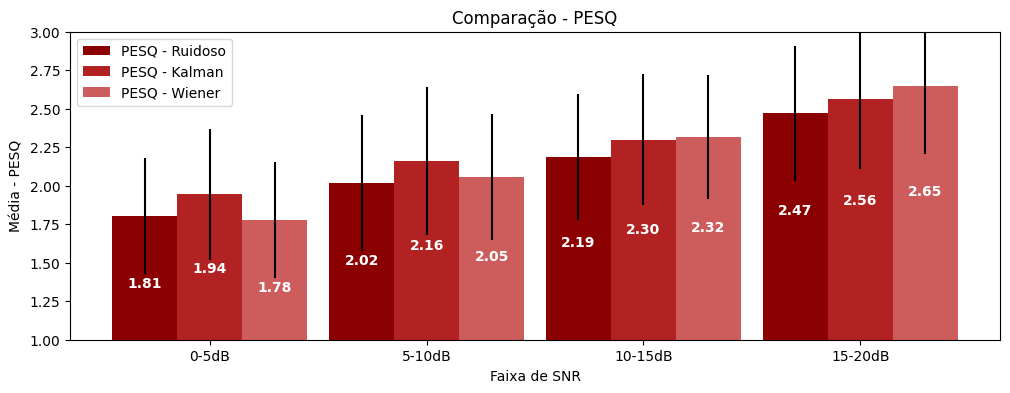

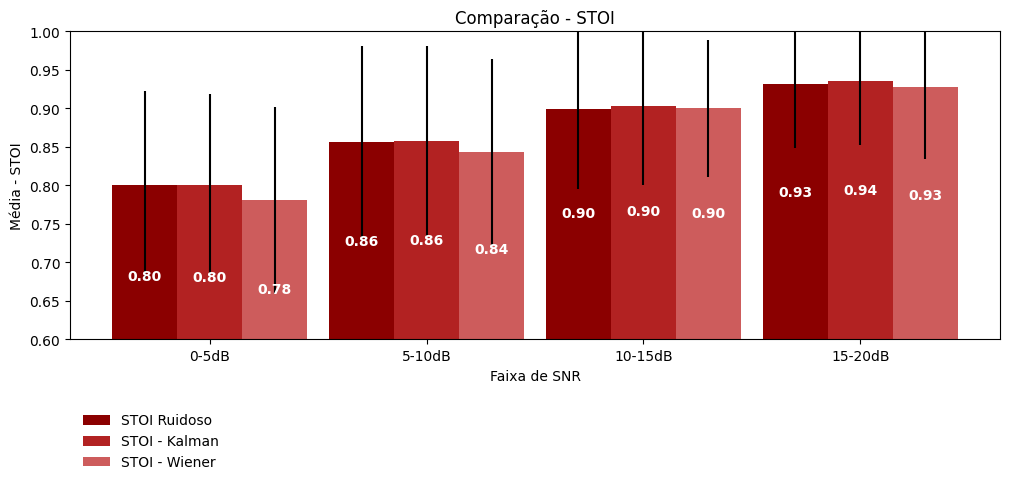

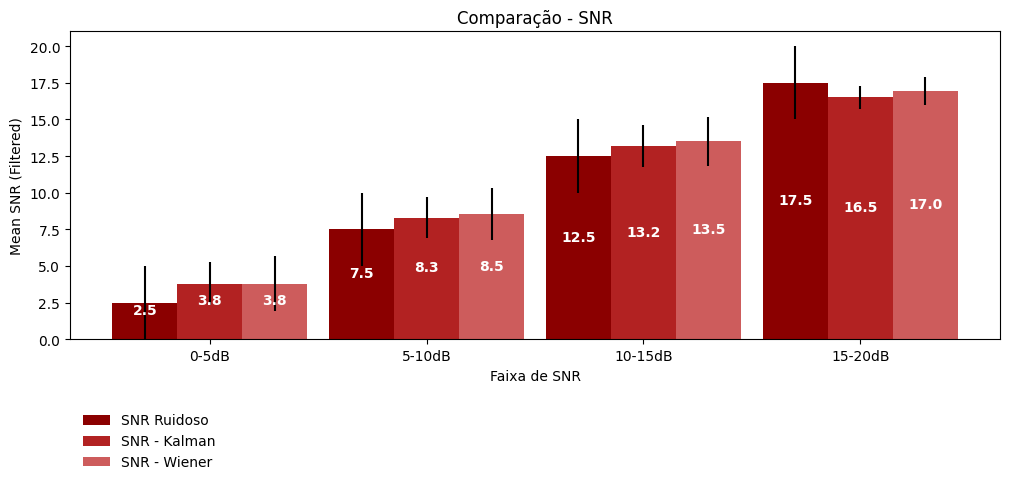

In [11]:
plot_summarized_results(result_kalman,'Kalman', result_wiener, 'Wiener')

In [12]:
def plot_summarized_results(df_list, df_names):
    # Defina o deslocamento horizontal para os gráficos
    n = len(df_list)
    bar_width = 0.09
    bar_positions = np.arange(len(df_list[0]['SNR Interval']))
    x_positions = [bar_positions + i * bar_width for i in range(n)]
    x_title = 'Faixa de SNR'
    figsize = (20, 7)
    pesq_thresholds = {
        "Excelente": (4.0, 4.5, 4.25),
        "Bom": (3.6, 3.99, 3.8),
        "Aceitável": (2.6, 3.59, 2.8),
        "Ruim": (1.6, 2.59, 1.8),
        "Muito Ruim": (0, 1.59, 0.8)
    }
    stoi_thresholds = {
        "Excelente": (0.75, 1.0, 0.875),
        "Boa": (0.5, 0.74, 0.625),
        "Baixa": (0, 0.49, 0.25)
    }
    colors = [
        '#8B4513',  # Brown
        '#A52A2A',  # Brown
        '#CD5C5C',  # IndianRed
        '#8B0000',  # DarkRed
        '#800000',  # Maroon
        '#800080',  # Purple
        '#B22222',  # FireBrick
        '#FF4500',  # OrangeRed
        '#A0522D',  # Sienna
        '#D2691E'   # Chocolate
    ]

    def autolabel(bars, hval=2, f=2):
        for bar in bars:
            height = bar.get_height()
            if f == 1:
                plt.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width() / 2, height/hval), xytext=(0, 3), textcoords='offset points',
                             ha='center', va='bottom', fontweight='bold', color='white')
            else:
                plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height/hval), xytext=(0, 3), textcoords='offset points',
                         ha='center', va='bottom', fontweight='bold', color='white')

    def plot_thresholds(plt, tresh_dics):
        for quality, (lower, upper, y_pos_plot) in tresh_dics.items():
            plt.axhline(y=lower, color='gray', linestyle='--', alpha=0.2)
            plt.text(-.38, y_pos_plot, quality, ha='left', va='center', color='gray')

    plt.figure(figsize=figsize)

    for i, (df, name_df, x_pos) in enumerate(zip(df_list, df_names, x_positions)):

        # Gráfico 1: PESQ, PESQ (Filtered) - df, PESQ (Filtered) - df1
        if i == 0:
            bars1 = plt.bar(x_pos - bar_width / 2, df['PESQ mean'], width=bar_width, label=f'PESQ - Ruidoso', yerr=df['PESQ std'], color=colors[i])
        bars2 = plt.bar(x_pos + bar_width / 2, df['PESQ (Filtered) mean'], width=bar_width, label=f'PESQ - {name_df}', yerr=df['PESQ (Filtered) std'], color=colors[i], alpha=0.5)

        autolabel(bars1, hval=1.4)
        autolabel(bars2, hval=1.4)

    plt.xlabel(x_title)
    plt.ylabel('Média - PESQ')
    plt.title('Comparação - PESQ')
    plt.xticks(bar_positions, df_list[0]['SNR Interval'])
    plt.ylim(0., 4.5)
    
    # Adicione as linhas de limiar PESQ
    # for quality, (lower, upper, y_pos_plot) in pesq_thresholds.items():
    #     plt.axhline(y=lower, color='gray', linestyle='--', alpha=0.5)
    #     plt.text(-.38, y_pos_plot, quality, ha='left', va='center', color='gray')
    plot_thresholds(plt, pesq_thresholds)

    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

    plt.figure(figsize=figsize)

    for i, (df, name_df, x_pos) in enumerate(zip(df_list, df_names, x_positions)):

        # Gráfico 2: STOI, STOI (Filtered) - df, STOI (Filtered) - df1
        if i == 0:
            bars1 = plt.bar(x_pos - bar_width / 2, df['STOI mean'], width=bar_width, label=f'STOI - Ruidoso', yerr=df['STOI std'], color=colors[i])
        bars2 = plt.bar(x_pos + bar_width / 2, df['STOI (Filtered) mean'], width=bar_width, label=f'STOI - {name_df}', yerr=df['STOI (Filtered) std'], color=colors[i], alpha=0.5)
        autolabel(bars1, hval=1.2)
        autolabel(bars2, hval=1.2)

    plt.xlabel(x_title)
    plt.ylabel('Média - STOI')
    plt.title('Comparação - STOI')
    plt.xticks(bar_positions, df_list[0]['SNR Interval'])
    plt.ylim(0., 1.0)
    
    # Adicione as linhas de limiar STOI
    for quality, (lower, upper, y_pos_plot) in stoi_thresholds.items():
        plt.axhline(y=lower, color='gray', linestyle='--', alpha=0.5)
        plt.text(-.38, y_pos_plot, quality, ha='left', va='center', color='gray')

    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

    plt.figure(figsize=figsize)

    for i, (df, name_df, x_pos) in enumerate(zip(df_list, df_names, x_positions)):

        # Gráfico 3: SNR, SNR (Filtered) - df, SNR (Filtered) - df1
        if i == 0:
            bars1 = plt.bar(x_pos - bar_width / 2, [2.5, 7.5, 12.5, 17.5], width=bar_width, label='SNR - Ruidoso', yerr=[2.5, 2.5, 2.5, 2.5], color=colors[i])
        bars2 = plt.bar(x_pos + bar_width / 2, df['SNR (Filtered) mean'], width=bar_width, label=f'SNR- {name_df}', yerr=df['SNR (Filtered) std'], color=colors[i], alpha=0.5)
        autolabel(bars1, f=1)
        autolabel(bars2, f=1)

    plt.xlabel(x_title)
    plt.ylabel('Média - SNR')
    plt.title('Comparação - SNR')
    plt.xticks(bar_positions, df_list[0]['SNR Interval'])
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    plt.show()

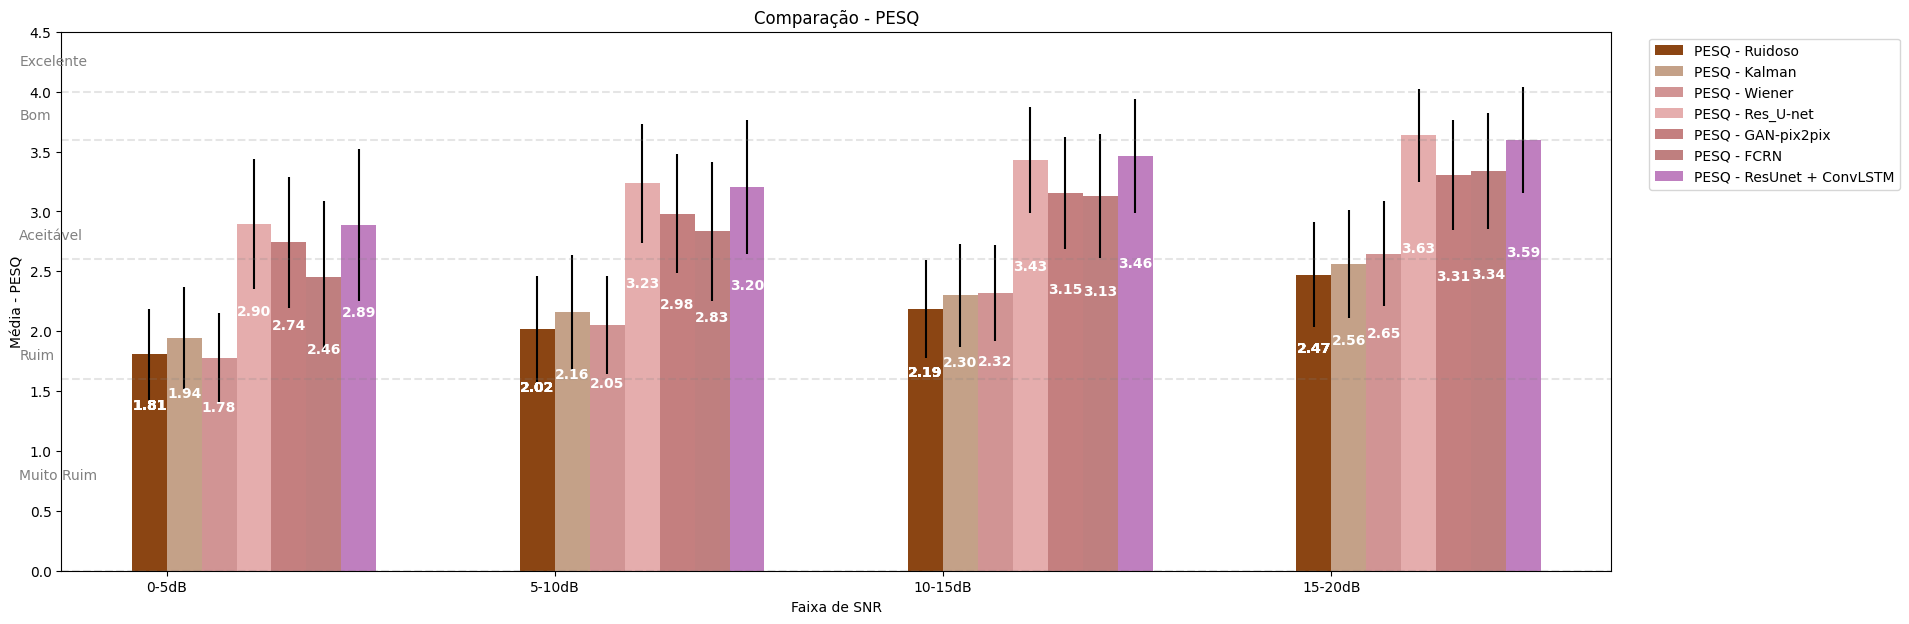

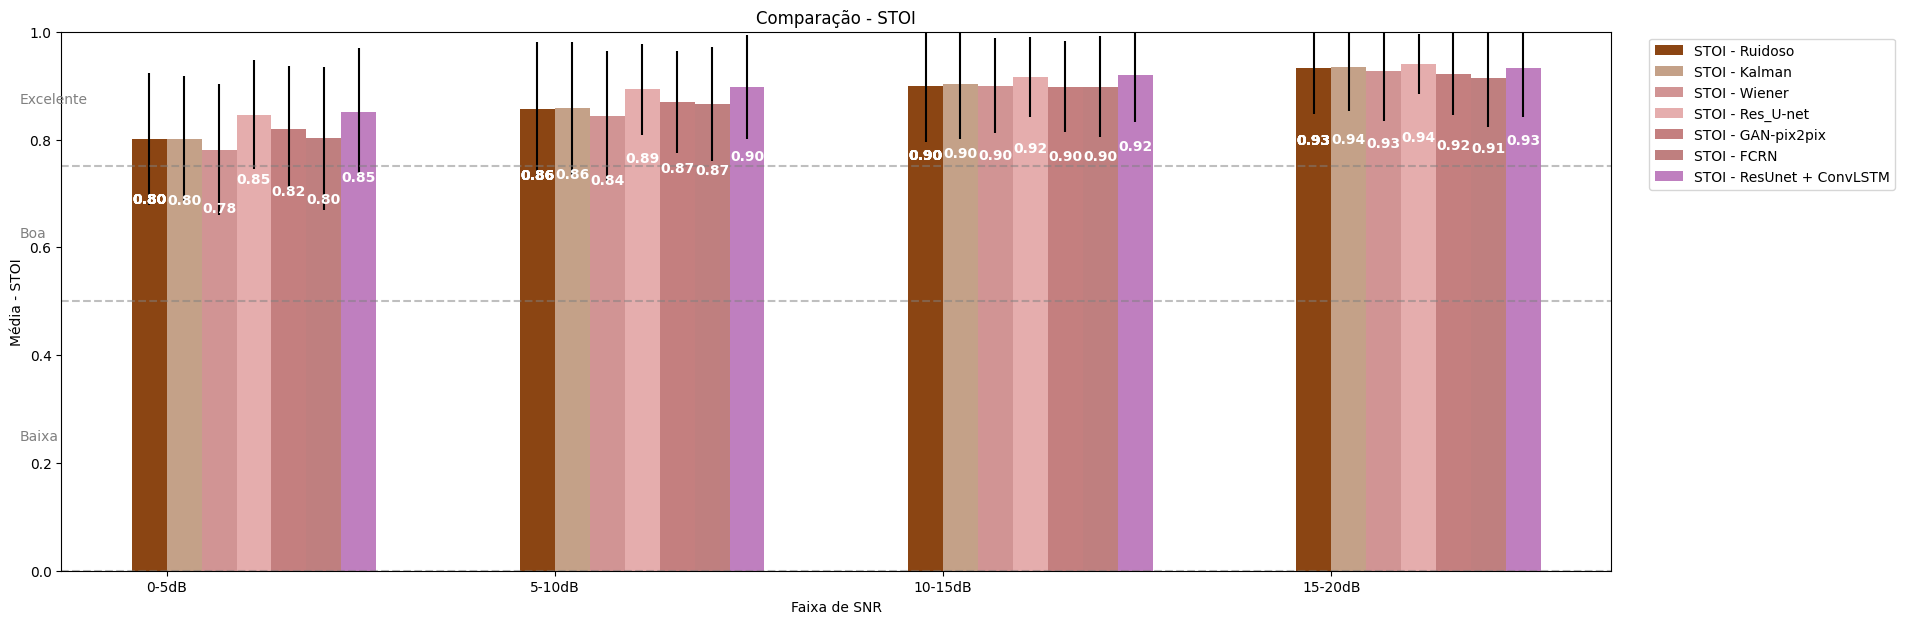

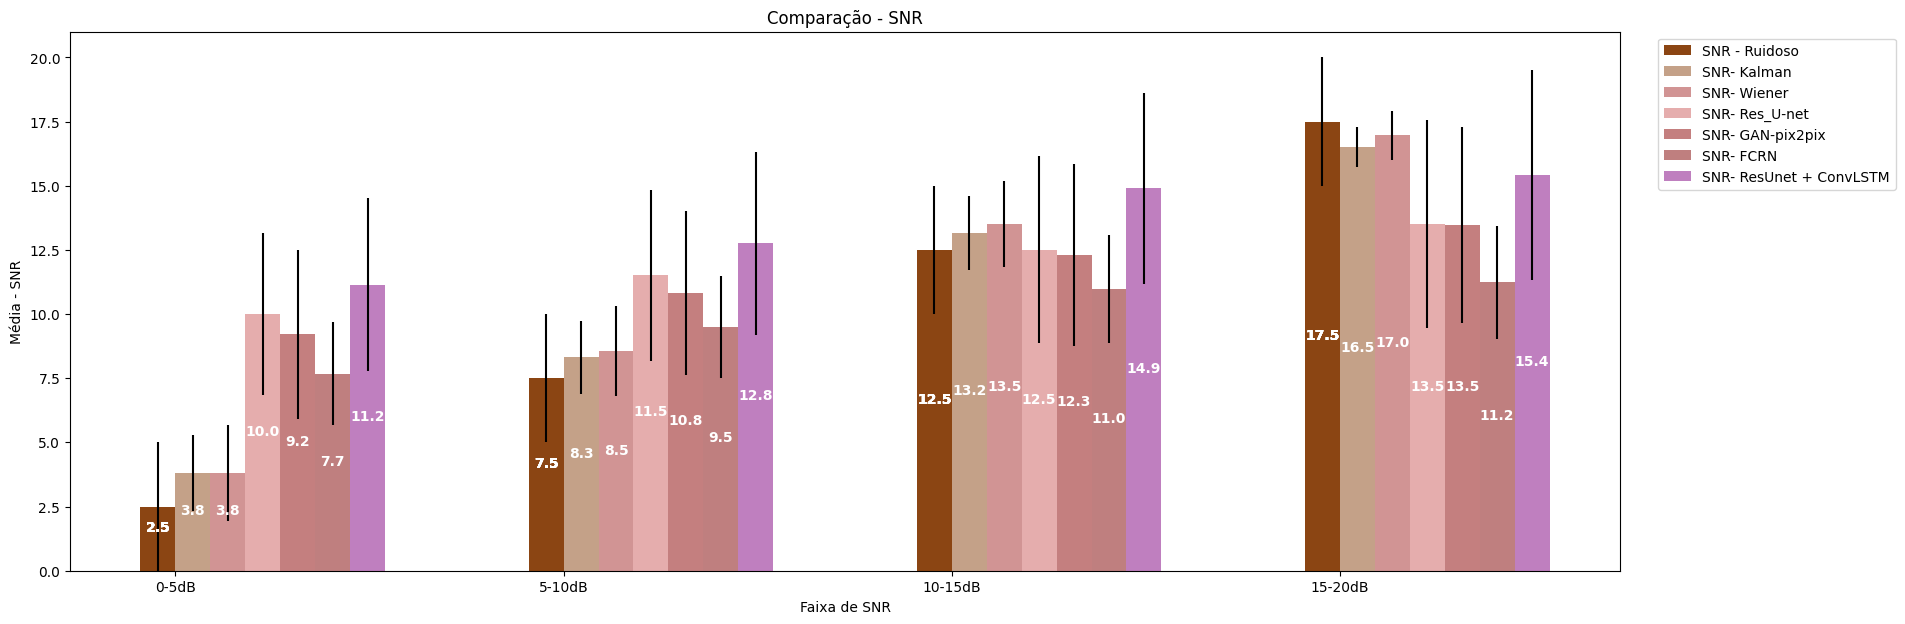

In [13]:
plot_summarized_results([result_kalman, result_wiener, result_unet, result_gan, result_fcrn, result_unetconv], ['Kalman', 'Wiener', 'Res_U-net', 'GAN-pix2pix', 'FCRN', 'ResUnet + ConvLSTM'])

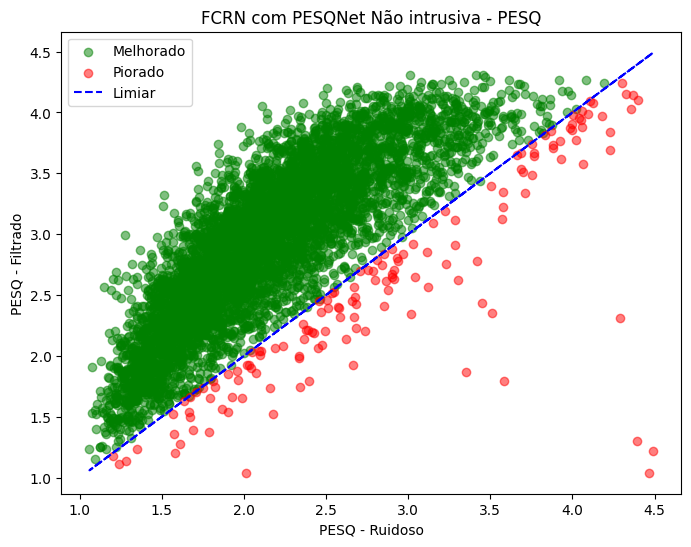

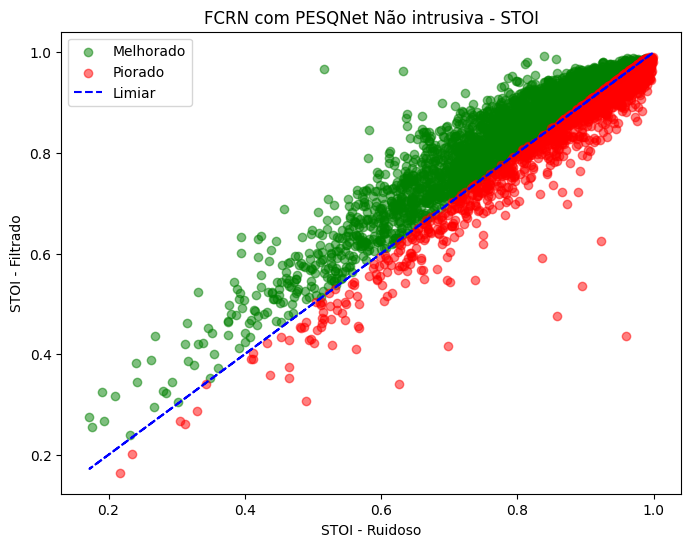

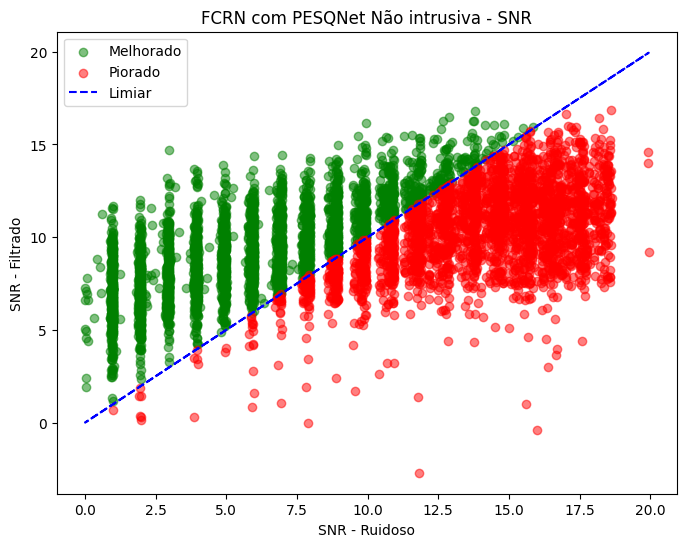

In [15]:
performance(df5, 'FCRN com PESQNet Não intrusiva', snr_lte=20.)

In [6]:
fileX = '/tf/Etapa 2/wiener_2024-04-12_21-23-26.xlsx'
dfX = pd.read_excel(fileX)

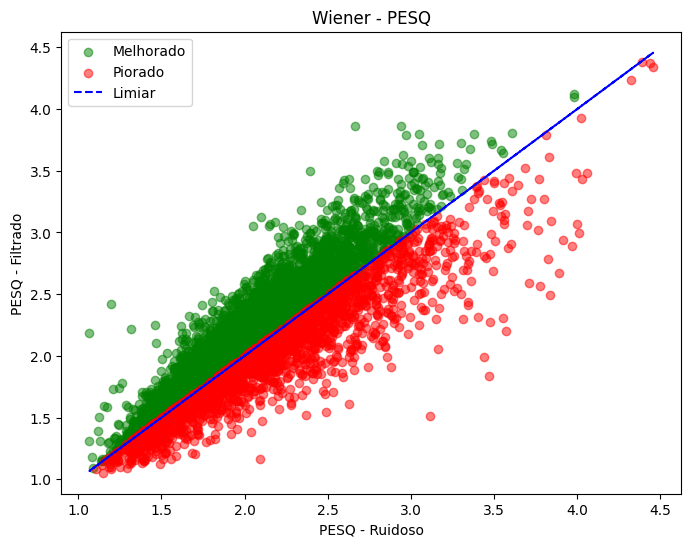

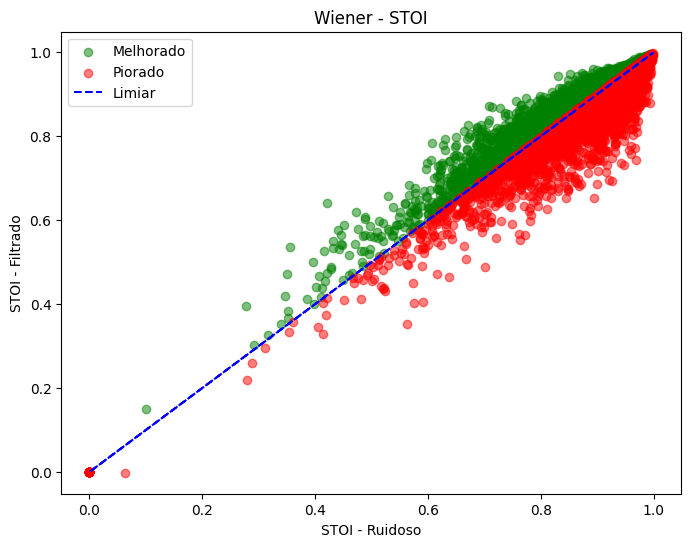

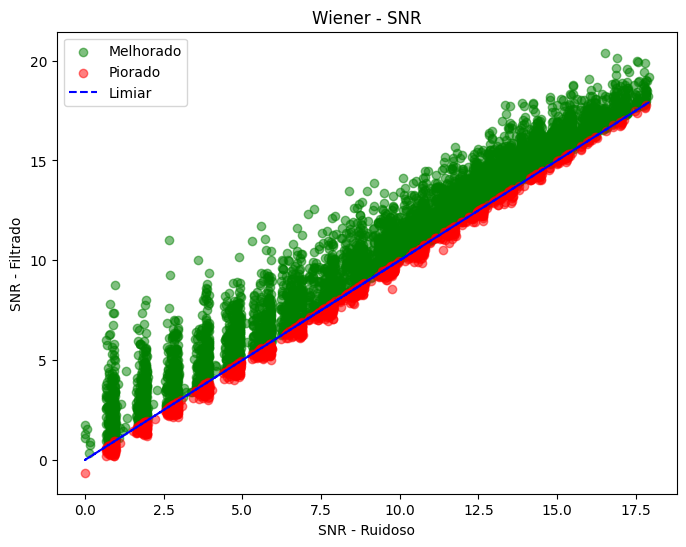

In [7]:
performance(dfX, 'Wiener')

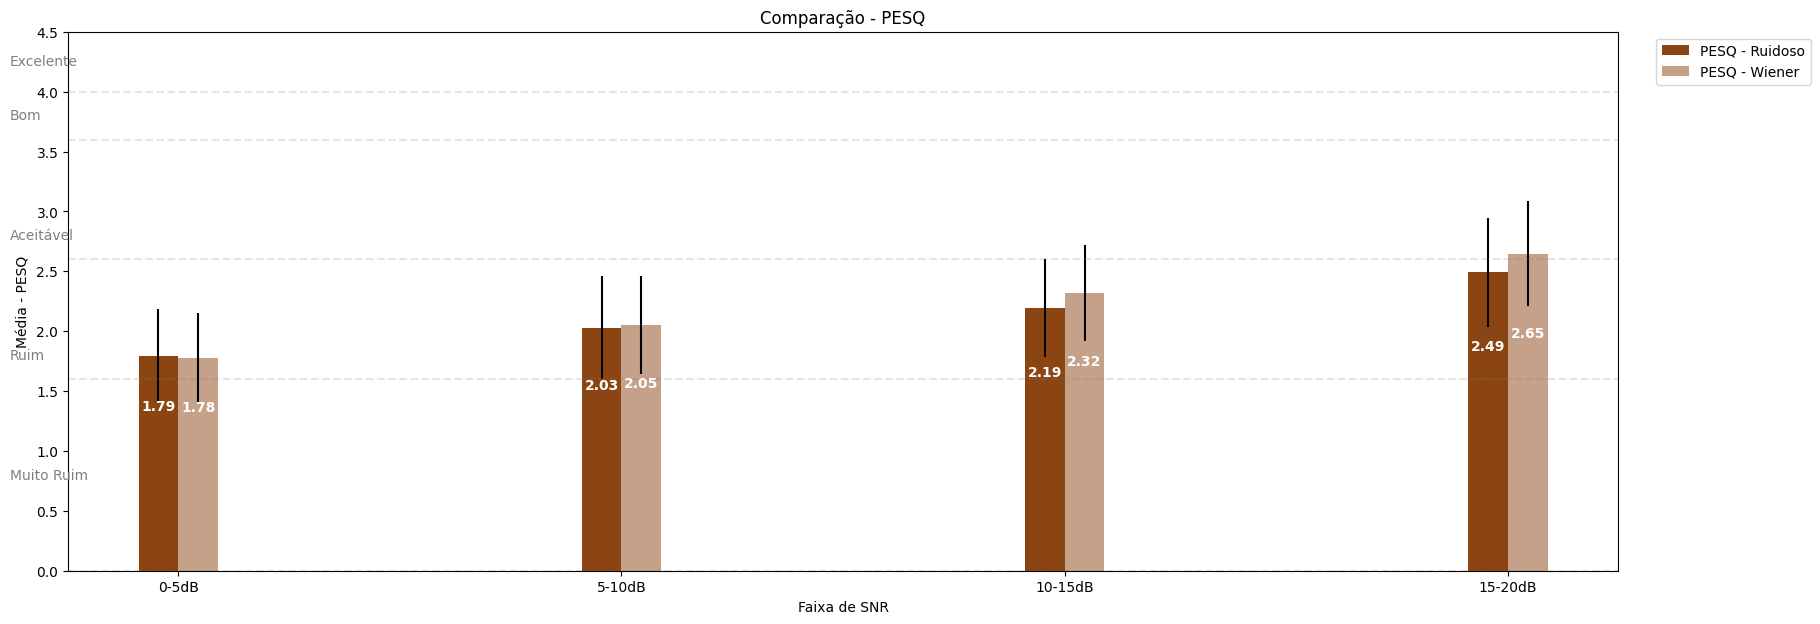

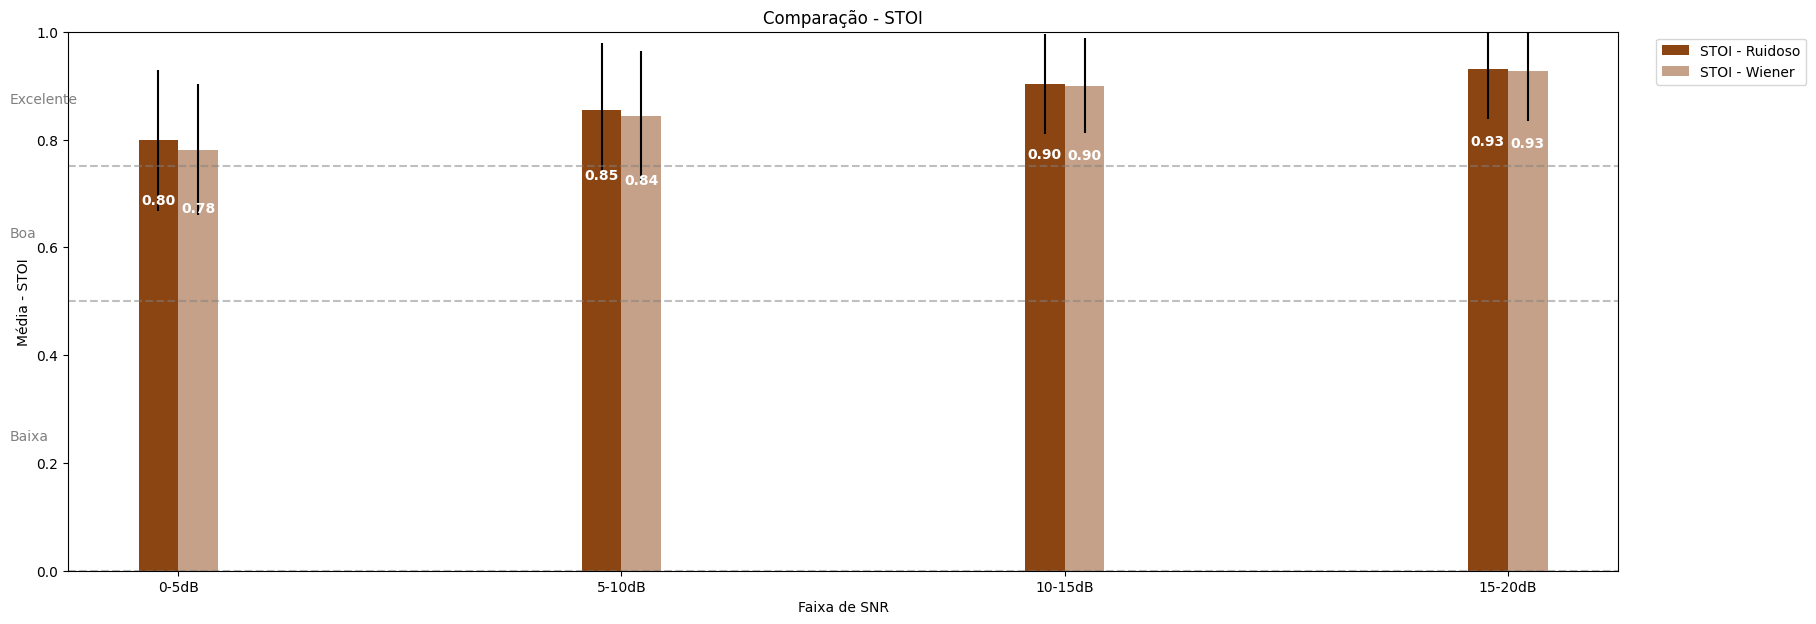

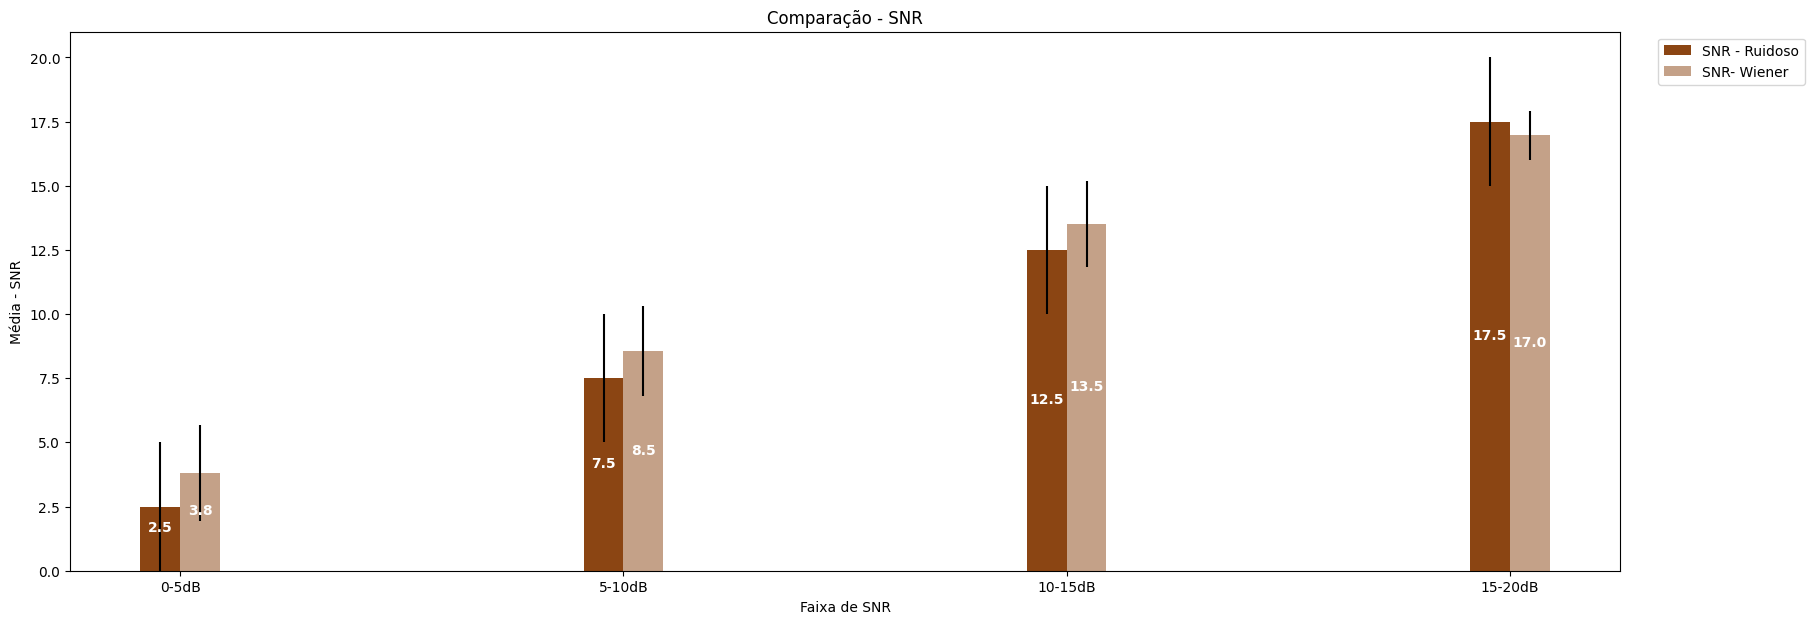

In [26]:
plot_summarized_results([result_wiener], ['Wiener',])